In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
from itertools import product
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

ImportError: /home/ron/.conda/envs/temporal_coding/lib/python3.6/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `CXXABI_1.3.9' not found (required by /home/ron/.conda/envs/temporal_coding/lib/python3.6/site-packages/scipy/sparse/_sparsetools.cpython-36m-x86_64-linux-gnu.so)

### Background
In [Synaptic theory of working memory, Mongillo et al. 2008](http://science.sciencemag.org/content/319/5869/1543),
a two parameter model for vesicle release and recovery is detailed.  
These two parameters are:  
$x$ : The fraction of vesicles available for release (from the maximum RRP)  
$u$ : The fraction of vesicles in $x$ that are released in response to a spike - This models the presynaptic intracellular states affecting release probabilites  


The behaviour of each of these is governed by the following differential equations:
$$
{dx\over dt} = {{1-x_{(t)}} \over \tau_D} - u_{(t)} x_{(t)}\delta(t-t_{sp})\\
{du\over dt} = {{U-u_{(t)}}\over \tau_f} + U(1-u_{(t)})(\delta(t-t_{st})
$$
where $U$ is some baseline value of $u$ towards which it grows or decays.
$tau_D$ and $tau_f$ are decay constants for $x$ and $u$ respectively, with $tau_f >> tau_D$

### Our model
Our model replaces the parameter $u$ with a parameter $p$ which represents the independent and identical release probability  
for each of the vesicles currently in the pool.  
The number of vesicles in the pool is governed by  
$${dn\over dt} = {{1\over \tau_n}\times (1-\delta(n_{(t)}-n_{max}))} - r_{(t)}$$
where   
$$r_{(t)} = p_{(t)}\times n_{(t)}$$
and thus
$${dn\over dt} = {{1\over \tau_n} \times (1-\delta(n_{(t)}-n_{max}))} - p_{(t)}\times n_{(t)}$$
$r_{(t)}$ is what we are essentially interested in, the number of vesicles released at each point in time.  
To derive it, we need to derive expressions for the behavior of $p_{(t)}$ somehow.

## Parameter derivation
### Constraints on $p_{(t)}$
We want the behavior of $p_{(t)}$ to be as follows:
1. It should decay to ~0 by the state change duration $-$ hereby noted as $d_{s}$
2. It should set the expected value of $r_{(t)}=p_{(t)}\times n_{(t)}$ to $n_{max}$  at $t=d_{lr}$ where $d_{lr}$ is the longest possible release duration, $\longrightarrow$ $\int_{0}^{d_{lr}}p_{(t)}\times n_{(t)}=n_{max}$
3. It should have a maximal value that it can not pass - a maximal probability $p_{max}$
4. It should quickly rise to that value following an action potential, regardless of its current value
5. At each specified actual release duration $d_{r}$


### Mathematical statement
Thus, the behavior of $p$ in time is composed of two parts:
$$ 
p_{decay} = {-p_{(t)}\over\tau_p} \\
p_{rise}=p_{max}\times \delta(t_{sp}-t) \\
{dp \over dt}=p_{decay}+p_{rise}\\
{dp \over dt}={-p_{(t)}\over \tau_p}+{(p_{max} - p_{(t)})\times \delta(t_{sp}-t)}\\
where:\ \  0 < p < p_{max}
$$
we are looking for values of $\tau_p$ and $p_{max}$ that will satisfy requirements 1-5.  

#### Deriving $\tau_p$
To satisfy requirement #1, we examine how $p$ would behave if it started at $p_{max}$ and only decayed to approximately 0 within $d_{s}$ ms,
for this, we restate the exponential decay function in its integrated form with the given values:  
$$
p_{(t)}=p_{max}\times e^{-t/ \tau_p}\\
p_{(d_{s})} \rightarrow 0\\
p_{(d_{s})} = 0 + eps
$$
We set the tolerance around zero to $eps = 10^{-4}$ and solve for $\tau_p$:
$$
p_{max}\times e^{-d_{s}/\tau_p}=10^{-4}\\
ln(p_{max}\times e^{-d_{s}/ \tau_p})=ln(10^{-4})\\
ln(p_{max})-{d_{s}\over \tau_p}=-4ln(10)\\
ln(p_{max})+4ln(10)={d_{s}\over \tau_p}\\
\tau_p(ln(p_{max})+4ln(10))=d_{s}\\
\tau_p={d_{s} \over ln(p_{max})+4ln(10)}
$$

#### Deriving $p_{max}$
To satisfy requirement #2, we again assume only decay, and that p start at its maximal value,  
and attempt to solve $\int_{0}^{t_{lr}}p_{(t)}\times n_{(t)}=n_{max}$ for $p_{(0)}=p_{max}$ and $n_{(0)}=n_{max}$  
these conditions reflect the behavior of $p$ when an action potential arrives while the pool is full.  

As we are assuming that a spike has just arrived, and are only interested in the behavior following a single spike,  
the rising part of $dp \over dt$ may be neglected such that we are again left with a simple exponential decay of $p_{(t)}$  
with a starting value of $p_{max}$, so as before:
$$
p_{(t)}=p_{max}\times e^{-t/\tau_p}
$$
only now we also have:
$$
\int_{0}^{d_{lr}}r_{(t)}=n_{max}\\
\int_{0}^{d_{lr}}p_{(t)}*n_{(t)}=n_{max}\\
\int_{0}^{d_{lr}}(p_{max}\times e^{-t/ \tau_p})\times (n_{(t)})=n_{max}
$$
for $n_{(t)}$, because under these conditions $t_{lr}$ < $tau_n$, and we start with a full vesicle pool $n_{max}$, we get:
$$
{dn\over dt} = -r_{(t)}\\
{dn\over dt} = -(p_{max}\times e^{-t/ \tau_p}\times n_{(t)})
$$
lets use sympy to develop this further:

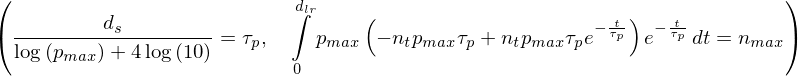

In [2]:
import sympy as sym
sym.init_printing()
p_max, n_max, n, t, p, tau_p, d_lr, d_s = sym.symbols(['p_max', 'n_max', 'n_t', 't', 'p', 'tau_p', 'd_lr', 'd_s'])
tau_p_exp = sym.Eq(d_s / (sym.log(p_max) + 4*sym.log(10)), tau_p)
p = p_max * sym.exp(-t/tau_p)
n_t = sym.Integral(-(p_max * sym.exp(-t/tau_p) *n), (t, 0, t)).doit()
r_t = p * n_t
intg_exp = sym.Eq(sym.Integral(r_t, (t, 0, d_lr)), n_max)
tau_p_exp, intg_exp

Integrating


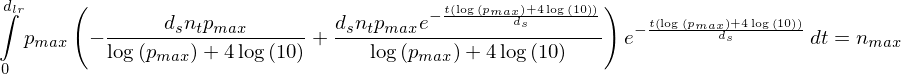

In [3]:
# sym.solve([tau_p_exp, intg_exp], (tau_p, p_max))
substituted = intg_exp.subs(tau_p, tau_p_exp.args[0])
print('Integrating')
substituted

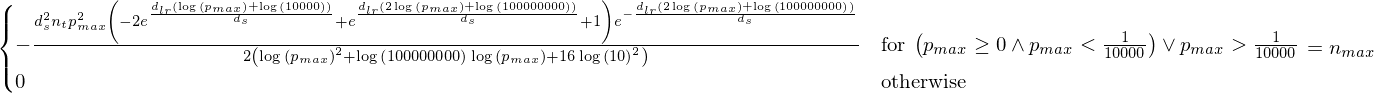

In [4]:
eq=sym.Eq(substituted.args[0].doit().simplify(), n_max)
eq

Now, to arrive at $p_{max}$ and $tau_p$, we solve this equation for the following parameter values:  
$
d_{lr} = 9 \\
d_{s} = 15 \\
n_{max} = 20 
$

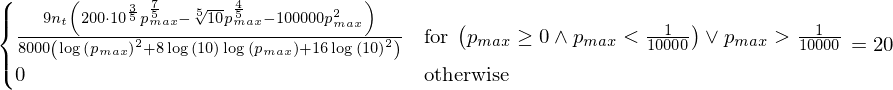

In [8]:
subs_eq = eq.subs([(d_lr, 9), (n_max, 20), (d_s, 15)]).simplify()
subs_eq

running the input through Wolfram alpha, we arrive at the following expression for $n_{(t)}$:
$$
n_{(t)} = n_{max} \times e ^ {\tau_p \times p_{max} \times e ^ {-t / \tau_p} }
$$
plugging these values in to the integral gives us:
$$
\int_{0}^{t_{lr}}(p_{max}\times n_{max}\times e^{-t/ \tau_p} \times e ^ {\tau_p \times p_{max} \times e ^ {-t / \tau_p} })=n_{max}
$$

solving the definite integral for $t_{lr}$ gives us:

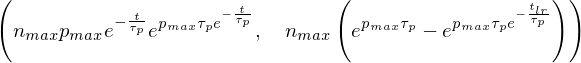

In [7]:
import sympy as sym
sym.init_printing()
p_max, n_max, t, tau_p, t_lr = sym.symbols(['p_max', 'n_max', 't', 'tau_p', 't_lr'])
expr = p_max * n_max * sym.exp(-t / tau_p) * sym.exp(tau_p * p_max * sym.exp(-t / tau_p))

intg_expr = sym.integrate(expr, (t, 0, t_lr)).simplify()
(expr, intg_expr)

$$
n_{max}(e^{\tau_p p_{max}} - e^{\tau_p p_{max}\times e^ {-t_{lr} / \tau_p}}) = n_{max}\\
e^{\tau_p p_{max}} - e^{\tau_p p_{max}\times e^ {-t_{lr} / \tau_p}} = 1
$$

We now substitue $\tau_p$ with the value derived above:
$$ \tau_p={t_{lr} \over ln(p_{max})+4ln(10)} $$

In [ ]:
tau_p_exp = t_lr / (sym.log(p_max) + 4*sym.log(10))
subs_intg_exp = intg_expr.subs(tau_p, tau_p_exp)
eq = sym.Eq(subs_intg_exp, n_max)
eq

Now, to arrive at $p_max$ and $tau_p$, we solve this equation for the following parameter values:  
$
t_{lr} = 9 \\
n_{max} = 20 
$

In [ ]:
assigned_expr = eq.subs([(t_lr, 9), (n_max, 20)]).
assigned_expr

Sympy seems unable to solve this expression,  
however wolfram alpha gives us a (somewhat dubious) value for $p_{max} = 0.679$.  
we assign this with previously mentioned values to determine $tau_p$:
$$ 
\tau_p={t_{lr} \over ln(p_{max})+4ln(10)} \\
\tau_p={9 \over ln(0.679)+4ln(10)} \\
\tau_p = 1.0200374
$$

Now lets examine a simple model using these values, we know that with the values specified,  
starting with a full pool, we should have no vesicles remaining after 9 ms.

In [ ]:
from scipy.integrate import solve_ivp
p_max_wolfram = 0.6796554826455
tau_p_computed = 9 / (np.log(p_max_wolfram) + 4 * np.log(10))
    
def test_diff(t, n, p, tau_p):
    dp = -p / tau_p
    r_t = p * n
    dn = -r_t
    return np.r_[dn, dp]

init_n = 20
init_p = p_max_wolfram
s = solve_ivp(fun=lambda t, y: test_diff(t, y[0], y[1], tau_p=tau_p_computed),
         t_span=(0, 20),
         y0=np.r_[init_n, init_p])

plt.plot(s.t, s.y[0])
plt.ylim([0, init_n]);

## Attempting manual derivation

Main functions

In [2]:
def tau_p(p_max, d_s=15, eps=1e-4):
    return d_s / (np.log(p_max) - np.log(eps))


def p_t(t, p_max, **kwargs):
    p = p_max * np.exp(-t / tau_p(p_max, **kwargs))
    return p


def dn_dt(t, n, p_max, **kwargs):
    r_t = p_t(t, p_max, **kwargs) * n
    return -r_t


def n(time_bins, p_max, init_n=20, **kwargs):
    integrated = solve_ivp(fun=lambda t, y: dn_dt(t, y, p_max, **kwargs),
                           t_span=(0, time_bins[-1]),
                           y0=(init_n,),
                           t_eval=time_bins)
    return integrated.y.squeeze()

Helper functions

In [3]:
def make_t_data(times, d_s, p_max, n_max, **kwargs):
    # Making sure our input variables can be interpreted as arrays if they are not already
    d_s_arr = np.r_[d_s]
    p_max_arr = np.r_[p_max]
    n_max_arr = np.r_[n_max]

    conditions = [
        {'d_s': d_s, 'p_max': p_max, 'n_max': n_max} for d_s, p_max, n_max in product(d_s_arr, p_max_arr, n_max_arr)]

    results = []
    for params in conditions:
        current_result = params.copy()
        param_dict = {key: params[key] for key in params if key != 'n_max'}
        current_p = p_t(times, **param_dict, **kwargs)
        current_n = n(times, init_n=params['n_max'], **param_dict, **kwargs)
        current_result.update({
            't': times,
            'p': current_p,
            'n': current_n,
        })
        results.append(pd.DataFrame(current_result))
    results = pd.concat(results)
    results['r'] = results.p * results.n
    return results

def _make_for_p_params(params, pmax_values, dt, **kwargs):
    times = np.arange(0 + dt, params['t'] + dt, dt)
    current_result = params.copy()
    current_p = p_t(params['t'], np.r_[pmax_values], d_s=params['d_s'], **kwargs)
    current_n = []
    for p_max in pmax_values:
        current_n.append(
            n(times, init_n=params['n_max'], p_max=p_max, d_s=params['d_s'], **kwargs)[-1])
    current_result.update({
        'p_max': pmax_values,
        'p': current_p,
        'n': current_n,
        't': [params['t']] * pmax_values.shape[0]
    })
    return pd.DataFrame(current_result)
def make_p_data(pmax_values, t, d_s, n_max, dt=0.01, **kwargs):
    # Making sure our input variables can be interpreted as arrays if they are not already
    t_arr = np.r_[t]
    d_s_arr = np.r_[d_s]
    n_max_arr = np.r_[n_max]

    conditions = [
        {'t': t, 'd_s': d_s, 'n_max': n_max} for t, d_s, n_max in product(t_arr, d_s_arr, n_max_arr)]

    # results = []
    # for params in conditions:
    #     results.append(_make_for_p_params(params, pmax_values, dt, **kwargs))
    with Pool(8) as P:
        results = P.starmap(_make_for_p_params, [(c, pmax_values, dt) for c in conditions])
    results = pd.concat(results)
    return results

def make_combo_data(times, combos, n_max, **kwargs):
    results = []
    for i, params in combos.iterrows():
        current_result = dict(params)
        current_result['n_max'] = n_max
        current_p = p_t(times, p_max=params['p_max'], d_s=params['d_s'], **kwargs)
        current_n = n(times, init_n=n_max, p_max=params['p_max'], d_s=params['d_s'], **kwargs)
        current_result.update({
            't': times,
            'p': current_p,
            'n': current_n,
        })
        results.append(pd.DataFrame(current_result))
    results = pd.concat(results)
    results['r'] = results.p * results.n
    return results

def plot_data(data, x='t', n_max=np.inf):
    pmax_values = np.unique(data.p_max)
    ds_values = np.unique(data.d_s)
    t_values = np.unique(data.t)
    if x == 't':
        ys = ['p', 'r', 'n']
        fig_shape = (len(ys), len(pmax_values))
        # fig, axarr = plt.subplots(len(ys), len(pmax_values), sharex=True, sharey='row')
        var_values = pmax_values
        var_name = 'p_max'
        hue = 'd_s'
    if (x == 'p_max') or (x == 'p'):
        x = 'p_max'
        ys = ['n', 'p']
        fig_shape = (len(ys), len(ds_values))
        # fig, axarr = plt.subplots(len(ys), len(t_values), sharex=True, sharey='row')
        var_values = ds_values
        var_name = 'd_s'
        hue = 't'

    fig, axarr = plt.subplots(*fig_shape, sharex=True, sharey='row')
    for i, (y, axrow) in enumerate(zip(ys, axarr)):
        if np.ndim(axrow) == 0:
            ax = axrow
            value = var_values
            plot_data = data[(data[var_name] == value[0]) & (data['n'] < n_max)]
            sns.lineplot(x=x, y=y, hue=hue, data=plot_data, ax=ax)
            if hue:
                ax.legend_.remove()
            if i == 0:
                ax.set_title(f'{var_name} = {value[0]}')
        else:
            for value, ax in zip(var_values, axrow):
                plot_data = data[(data[var_name] == value) & (data['n'] < n_max)]
                sns.lineplot(x=x, y=y, hue=hue, data=plot_data, ax=ax)
                if hue:
                    ax.legend_.remove()
                if i == 0:
                    ax.set_title(f'{var_name} = {value}')
    if hue:
        if axarr.ndim == 2:
            axarr[0, 0].legend(np.unique(data[hue]))
        else:
            axarr[0].legend(np.unique(data[hue]))

def plot_combo(combo_data):
    ds_values = np.unique(combo_data.d_s)
    pmax_values = np.unique(combo_data.p_max)

    x = 't'
    ys = ['p', 'r', 'n']
    hue = 'd_s'
    fig_shape = (len(ys), len(pmax_values))

    fig, axarr = plt.subplots(*fig_shape, sharex=True, sharey='row')
    for i, (y, axrow) in enumerate(zip(ys, axarr)):
        for j, (p_max, ax) in enumerate(zip(pmax_values, axrow)):
            plot_data = combo_data[combo_data['p_max'] == p_max]
            sns.lineplot(x=x, y=y, data=plot_data, ax=ax)
            if i==0:
                ax.set_title(f'p_max={p_max} | d_s={np.unique(plot_data.d_s)}')

In [6]:
d_lr = 9
n_max = 20

pmax_range = (0.5, 5)
n_pmax = 100
ds_range = (30, 1000)
n_ds = 100

dt = 0.01  # ms

t_values = [3, 6, 9]
# Setup logarithmically space values
pmax_values = np.linspace(*pmax_range, num=n_pmax)
ds_values = np.linspace(*ds_range, num=n_ds)
# pmax_values = np.logspace(*np.log10(pmax_range), num=n_pmax, endpoint=False)
# ds_values = np.logspace(*np.log10(ds_range), num=n_ds, endpoint=False).round()
# ds_values = np.logspace(np.log10(30), np.log10(1000), 4, endpoint=False).round()

mecha_data = make_p_data(pmax_values=pmax_values, t=t_values,
                     d_s=ds_values, n_max=n_max, dt=dt)

In [2]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
iplot([{"x": [1, 2, 3], "y": [3, 1, 6]}])

/home/ron/.conda/envs/temporal_coding/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
